# COMP2002 Assessment

This notebook will contain demonstrations of:
- Regression models trained to predict the Fire Weather Index (FWI) at a given time based on 12 numerical inputs from records of forest fires in 2 regions of Algeria.
- Optimisers designed to optimise routes between cities in the Travelling Salesman Problem.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from random import shuffle

### Regression

In [2]:
# Load forest file data using Pandas
forest_fire_region_1_data = pd.read_csv("./data/AlgerianFF_Region1.csv")
forest_fire_region_2_data = pd.read_csv("./data/AlgerianFF_Region2.csv")

In [3]:
# Copy data to avoid making permanent unrecoverable changes to the original
forest_fire_region_1_training_data = forest_fire_region_1_data.copy()
forest_fire_region_2_training_data = forest_fire_region_2_data.copy()

# Seperate FWI from the rest of the data, as this is the output we want to generate
forest_fire_region_1_training_targets = forest_fire_region_1_training_data.pop("FWI")
forest_fire_region_2_training_targets = forest_fire_region_2_training_data.pop("FWI")

In [4]:
# Create separate scalers for each dataset
ffr_1_scaler = MinMaxScaler()
ffr_2_scaler = MinMaxScaler()

# Fit each scaler on its own dataset
ffr_1_scaler.partial_fit(forest_fire_region_1_training_data)
ffr_1_scaler.partial_fit(forest_fire_region_2_training_data)

# Normalise each dataset using the now fitted scalers
scaled_ffr_1_training_data = ffr_1_scaler.transform(forest_fire_region_1_training_data)
scaled_ffr_2_training_data = ffr_1_scaler.transform(forest_fire_region_2_training_data)
print(scaled_ffr_1_training_data.ptp(axis=0))
print(scaled_ffr_2_training_data.ptp(axis=0))

[1.         1.         0.         0.75       0.63768116 0.65217391
 1.         0.91543027 0.82055215 1.         0.65789474 0.99103139]
[1.         1.         0.         0.9        1.         1.
 0.51785714 0.8620178  0.99693252 0.79625293 0.99473684 0.9955157 ]


In [5]:
# Initialise regressor objects
random_forest_regressor = RandomForestRegressor(n_estimators=100)
# Set activaion to tanh and solver to lbfgs for better performance on smaller datasets
neural_network_regressor = MLPRegressor(solver='lbfgs', activation='tanh')
# Set kernel to linear for better performance
support_vector_regressor = SVR(kernel='linear', C=6.0)

In [6]:
# Train regressors on training data
random_forest_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)
neural_network_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)
support_vector_regressor.fit(scaled_ffr_1_training_data, forest_fire_region_1_training_targets)

SVR(C=6.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [7]:
def test_on_point_in_dataset(regressor, point_index):
    prediction = regressor.predict(scaled_ffr_1_training_data[point_index].reshape(1, 12))
    prediction_string = f"Real: {forest_fire_region_1_training_targets[point_index]}\nPredicted by regressor: {prediction[0]}"
    return prediction_string

In [8]:
# Use trained random forest regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(random_forest_regressor, 0))

Real: 0.5
Predicted by regressor: 0.5059999999999999


In [9]:
# Use trained neural network regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(neural_network_regressor, 0))

Real: 0.5
Predicted by regressor: 0.6193179574347214


In [10]:
# Use trained support vector regressor to predict the first point in the training dataset
print(test_on_point_in_dataset(support_vector_regressor, 0))

Real: 0.5
Predicted by regressor: 0.40019701075236347


In [11]:
def get_mae_from_testing_data(regressor, testing_data, testing_targets):
    predictions = regressor.predict(testing_data)
    return mean_absolute_error(testing_targets, predictions)

In [12]:
def plot_mae_data(mae_data):
    # Create list of labels and colours for plotting
    labels = ["Random Forest Regressor", "Neural Network Regressor", "Support Vector Regressor"]
    colors = ["blue", "red", "green"]

    # Alter figsize to avoid overlapping tick labels
    plt.figure(figsize=(9.6, 7.2))
    plt.bar([0, 1, 2], mae_data, color=colors, tick_label=labels)
    plt.ylabel("Mean Absolute Error rate")
    plt.show()

[1.158688524590163, 0.4357298556372547, 0.6680912805030614]


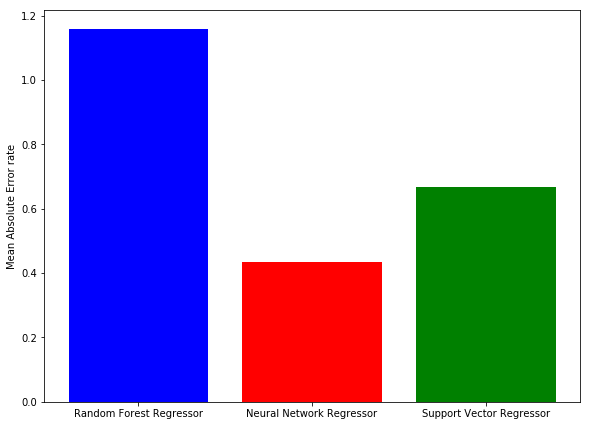

In [13]:
rf_mae = get_mae_from_testing_data(random_forest_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
nn_mae = get_mae_from_testing_data(neural_network_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
sv_mae = get_mae_from_testing_data(support_vector_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)

mae_data = [rf_mae, nn_mae, sv_mae]
print(mae_data)
plot_mae_data(mae_data)

In [14]:
def get_cross_validation_scores(regressor, testing_data, testing_targets):
    return cross_val_score(regressor, testing_data, testing_targets, cv=5)

In [15]:
def plot_cross_validation(cross_validation_data):
    # Set up labels
    regressor_labels = ["Random Forest Regressor", "Neural Network Regressor", "Support Vector Regressor"]
    # Set figsize to avoid labels overlapping
    plt.figure(figsize=(9.6, 7.2))
    # Plot data with labels
    plt.boxplot(cross_validation_data, labels=regressor_labels)
    plt.hlines(1, 0, 4, label="Best possible score")
    
    
    plt.show()

In [16]:
random_forest_scores = get_cross_validation_scores(random_forest_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
neural_network_scores = get_cross_validation_scores(neural_network_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)
support_vector_scores = get_cross_validation_scores(support_vector_regressor, scaled_ffr_2_training_data, forest_fire_region_2_training_targets)

[0.97554129 0.9525967  0.94518828 0.86972138 0.98420234] [0.93514595 0.97054789 0.90730211 0.96957739 0.99033067] [0.96533053 0.99450886 0.87582752 0.97236218 0.98179134]


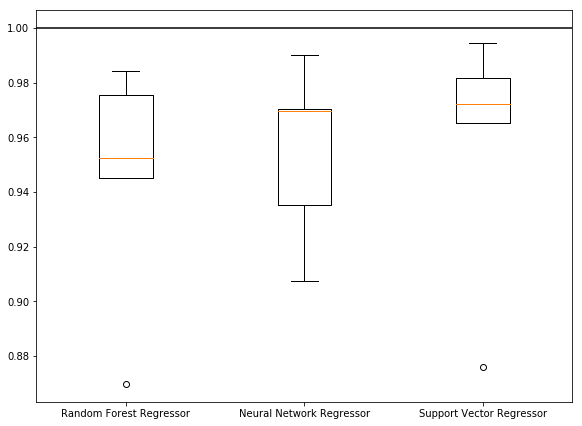

In [17]:
print(random_forest_scores, neural_network_scores, support_vector_scores)
plot_cross_validation((random_forest_scores, neural_network_scores, support_vector_scores))

### Optimisation

In [18]:
cities_long_filename = "./data/cities.txt"
cities_short_filename = "./data/cities_short.txt"
distance_long_filename = "./data/distances.csv"
distance_short_filename = "./data/distances_short.csv"

In [19]:
def get_total_distance_of_route(route, distance_data):
    total_distance = 0
    for city_index in range(0, len(route) - 1):
        city_from, city_to = route[city_index], route[city_index + 1]
        single_distance = distance_data[city_from][city_to]
        total_distance += single_distance
    
    return total_distance

In [20]:
def get_cities(cities_filename):
    with open(cities_filename) as cities_file:
        # Read and use splitlines rather than readlines to avoid \n characters on the end of city names
        cities = cities_file.read().splitlines()
        return cities

In [21]:
def get_distance_data(cities_filename, distance_filename):
    # Get long cities
    cities = get_cities(cities_filename)
    # Read CSV and specify seperator in order to use faster C implementation of CSV reader
    distance = pd.read_csv(distance_filename, sep=",", names=cities)
    # Set index names seperately as this is not an option in the read_csv method
    distance.index = cities
    
    return (cities, distance)

In [22]:
cities_long, distance_long = get_distance_data(cities_long_filename, distance_long_filename)
cities_short, distance_short = get_distance_data(cities_short_filename, distance_short_filename)

display(distance_long)
display(distance_short)

,Cardiff,Swansea,Bangor,Glasgow,Edinburgh,Inverness,Aberdeen,London,Plymouth,Bristol,Southampton,Norwich,Birmingham,Manchester,Liverpool,Cambridge,Brighton,Oxford,Newcastle,Leeds
Cardiff,0.0,41.2,180.0,392.0,394.0,547,525,151.0,152,53.0,134.0,266.0,124.0,188.0,200.0,202.0,191.0,118.0,323.0,227.0
Swansea,41.2,0.0,157.0,428.0,430.0,583,560,187.0,187,92.1,169.0,302.0,160.0,224.0,165.0,242.0,227.0,154.0,358.0,263.0
Bangor,180.0,157.0,0.0,295.0,297.0,451,428,266.0,347,233.0,291.0,307.0,152.0,96.3,70.0,247.0,325.0,210.0,240.0,139.0
Glasgow,392.0,428.0,295.0,0.0,46.5,168,145,414.0,485,372.0,429.0,376.0,290.0,216.0,221.0,357.0,463.0,364.0,152.0,221.0
Edinburgh,394.0,430.0,297.0,46.5,0.0,156,127,403.0,487,373.0,431.0,373.0,292.0,217.0,222.0,354.0,465.0,366.0,120.0,218.0
Inverness,547.0,583.0,451.0,168.0,156.0,0,104,561.0,641,528.0,585.0,533.0,447.0,373.0,378.0,514.0,619.0,521.0,282.0,378.0
Aberdeen,525.0,560.0,428.0,145.0,127.0,104,0,539.0,620,506.0,563.0,510.0,425.0,351.0,355.0,491.0,597.0,499.0,254.0,356.0
London,151.0,187.0,266.0,414.0,403.0,561,539,0.0,215,118.0,80.1,118.0,126.0,208.0,221.0,64.0,53.5,56.1,290.0,195.0
Plymouth,152.0,187.0,347.0,485.0,487.0,641,620,215.0,0,121.0,152.0,359.0,211.0,281.0,293.0,299.0,217.0,205.0,416.0,321.0
Bristol,53.0,92.1,233.0,372.0,373.0,528,506,118.0,121,0.0,101.0,246.0,97.5,168.0,180.0,186.0,159.0,85.2,302.0,207.0


,Plymouth,Bristol,London,Cardiff,Edinburgh
Plymouth,0,394,151,152,53
Bristol,394,0,403,487,373
London,151,403,0,215,118
Cardiff,152,487,215,0,121
Edinburgh,53,373,118,121,0


In [23]:
default_long_distance = get_total_distance_of_route(cities_long, distance_long)
default_short_distance = get_total_distance_of_route(cities_short, distance_short)
print(default_long_distance)
print(default_short_distance)

3037.4999999999995
1133


In [24]:
def get_random_route(cities_filename):
    cities = get_cities(cities_filename)
    shuffle(cities)
    return cities

In [26]:
for i in range(0, 3):
    random_long = get_random_route(cities_long_filename)
    print(random_long)
    print(get_total_distance_of_route(random_long, distance_long))
    
for i in range(0, 3):
    random_short = get_random_route(cities_short_filename)
    print(random_short)
    print(get_total_distance_of_route(random_short, distance_short))

['Aberdeen', 'Liverpool', 'London', 'Cambridge', 'Leeds', 'Southampton', 'Newcastle', 'Manchester', 'Birmingham', 'Brighton', 'Plymouth', 'Cardiff', 'Bristol', 'Swansea', 'Glasgow', 'Edinburgh', 'Inverness', 'Oxford', 'Norwich', 'Bangor']
3881.7999999999997
['Newcastle', 'Brighton', 'Cardiff', 'Oxford', 'Cambridge', 'London', 'Plymouth', 'Birmingham', 'Edinburgh', 'Bristol', 'Glasgow', 'Manchester', 'Inverness', 'Swansea', 'Bangor', 'Norwich', 'Leeds', 'Liverpool', 'Southampton', 'Aberdeen']
4951.0
['Liverpool', 'Plymouth', 'Swansea', 'Southampton', 'Bangor', 'Newcastle', 'Glasgow', 'Oxford', 'Inverness', 'Bristol', 'Cardiff', 'London', 'Brighton', 'Manchester', 'Edinburgh', 'Aberdeen', 'Leeds', 'Cambridge', 'Norwich', 'Birmingham']
4335.4
['Plymouth', 'Edinburgh', 'Cardiff', 'London', 'Bristol']
792
['Cardiff', 'Bristol', 'Edinburgh', 'Plymouth', 'London']
1064
['Bristol', 'Plymouth', 'Cardiff', 'London', 'Edinburgh']
879


In [28]:
def less_than_or_equal(score_1, score_2):
    return score_1 <= score_2

In [30]:
def solve(parent_solution, parent_score, distance, mutation_function, archive):
    
    # Mutate parent solution to create child
    child_solution = mutation_function(parent_solution)
    
    # Evaluate child
    child_solution_score = get_total_distance_of_route(child_solution, distance)
    
    # Compare parent and child, if child solution is better then
    if less_than_or_equal(child_solution_score, parent_solution_score):
        best_solution = child_solution
        best_solution_score = child_solution
    else:
        best_solution = parent_solution
        best_solution_score = parent_solution_score
    
    archive.append(best_solution)
    return best_solution, best_solution_score, archive
        

In [31]:
def optimise(cities_filename, distance_filename, mutation_function, iterations):
    
    cities, distance = get_distance_data(cities_filename, distance_filename)
    # Generate random solution to start with
    best_solution = get_random_route(cities_filename)
    
    # Evaluate random solution
    best_solution_score = get_total_distance_of_route(best_solution, distance)
    
    archive = []
    
    for iteration in range(0, iterations):
        # Create new solutions
        best_solution, best_solution_score, archive = solve(best_solution, best_solution_score, mutation_function, archive)
    
    return best_solution, best_solution_score, archive
    